<a href="https://colab.research.google.com/github/jiwon5315/BusinessAnalystPortfolio/blob/main/RFM_Analysis_for_Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Inspired by the RFM chapter in the book **R All-in-One For Dummies** written by Joseph Schmuller*

📖 **Background**
RFM analysis stands for Recency-Frequency-Monetary values. The UC Irvine Machine Learning Repository has the [Online Retail](http://archive.ics.uci.edu/dataset/352/online+retail) dataset - which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

💾 **Data Columns**
: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

✅ **Goal**
1. We want to identify the top customers based on RFM results. Who are the top 20%?
2. Based on the RFM scores, identify 'Champion' and 'Lost' customers.
3. Summarize the key difference between the two customer segments.

In [19]:
install.packages('readxl')
library(readxl)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
retailonline <- read_xlsx('/OnlineRetail.xlsx')
head(retailonline)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom


In [5]:
#RFM in R
install.packages('didrooRFM')
library(didrooRFM)
retailonline$Amount <- retailonline$Quantity*retailonline$UnitPrice

#Prepping data for analysis
#--Create dataframe with unique invoice number and invoice date
firstPart <- unique(retailonline[,c('InvoiceNo','CustomerID','InvoiceDate')])
#--Create dataframe with unique invoice number and total amount
secondPart <- aggregate(list(Amount=retailonline$Amount),
                        by=list(InvoiceNo=retailonline$InvoiceNo), FUN=sum)
#--merge the two dataframes
dataRFM <- merge(firstPart,secondPart, by="InvoiceNo")
#--reformat InvoiceDate
dataRFM$InvoiceDate <- as.Date(dataRFM$InvoiceDate, format="%m/%d/%Y")
#--Remove rows without Customer ID
dataRFM <- na.omit(dataRFM)
summary(dataRFM)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



  InvoiceNo           CustomerID     InvoiceDate             Amount          
 Length:22221       Min.   :12346   Min.   :2010-12-01   Min.   :-168469.60  
 Class :character   1st Qu.:13755   1st Qu.:2011-03-28   1st Qu.:     88.25  
 Mode  :character   Median :15136   Median :2011-07-08   Median :    241.74  
                    Mean   :15238   Mean   :2011-06-29   Mean   :    374.39  
                    3rd Qu.:16746   3rd Qu.:2011-10-10   3rd Qu.:    418.22  
                    Max.   :18287   Max.   :2011-12-09   Max.   : 168469.60  

MeanValue,LastTransaction,NoTransaction
<dbl>,<date>,<int>
0.0000,2011-01-18,2
615.7143,2011-12-07,7
449.3100,2011-09-25,4
1757.5500,2011-11-21,1
334.4000,2011-02-02,1
140.4918,2011-11-03,11


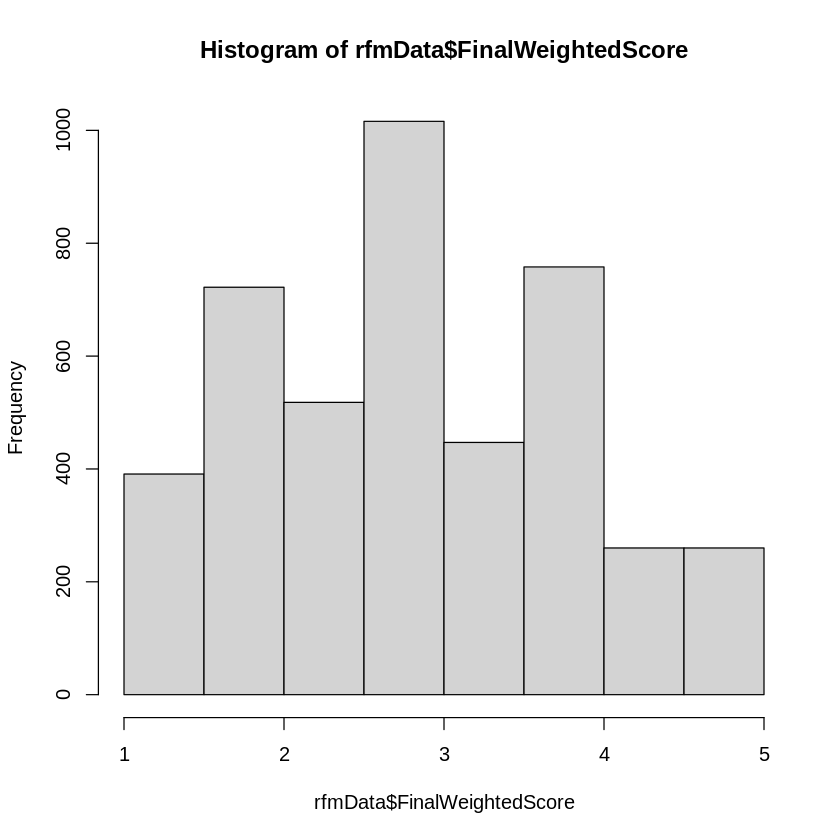

In [51]:
resultsRFM <- findRFM(dataRFM)
head(resultsRFM[,c('MeanValue','LastTransaction','NoTransaction')])

In [11]:
head(resultsRFM[,c('RecencyScore','FrequencyScore','MonetoryScore',
  'FinalCustomerClass')])

RecencyScore,FrequencyScore,MonetoryScore,FinalCustomerClass
<dbl>,<dbl>,<dbl>,<chr>
1,2,1,Class-1
5,4,5,Class-4
2,3,5,Class-3
4,1,5,Class-3
1,1,4,Class-2
3,5,2,Class-3


In [12]:
tblClass <- table(resultsRFM$FinalCustomerClass)
tblClass


Class-1 Class-2 Class-3 Class-4 Class-5 
    705    1442    1344     797      84 

**Class 5** = Top 20% of Customers

: There are 84 customers categorized as Class 5

**Class 1** = Bottom 20% of Customers

: There are 705 customers categorized as Class 1

In [18]:
install.packages('ggplot2')
library(ggplot2)
resultsRFM$Segment <- ifelse(resultsRFM$RecencyScore >= 4 &
                               resultsRFM$FrequencyScore >= 4 &
                               resultsRFM$MonetoryScore >= 4,
                             "Champion",
                             ifelse(resultsRFM$RecencyScore <= 1 &
                                      resultsRFM$FrequencyScore <= 1,
                                    "Lost",
                                    "Other"))
resultsRFM$Segment <- factor(resultsRFM$Segment, levels = c("Champion", "Other", "Lost"))
summary(resultsRFM$Segment)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Champion    Other     Lost 
     412     3412      548

Champion customers are those with a recency, frequency, and monetary score all >= 4, whereas lost customers are those with recency and frequency score of 1.
There are more lost customers than champion customers.

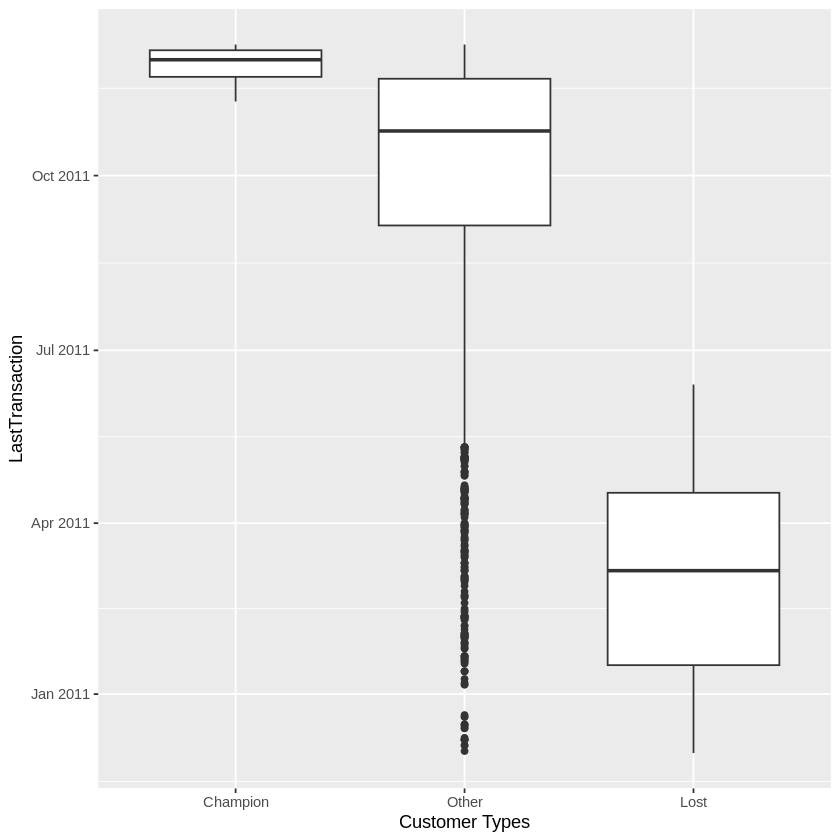

In [17]:
#Recency comparison
ggplot(resultsRFM, aes(x=Segment,y=LastTransaction))+geom_boxplot()+labs(x="Customer Types")

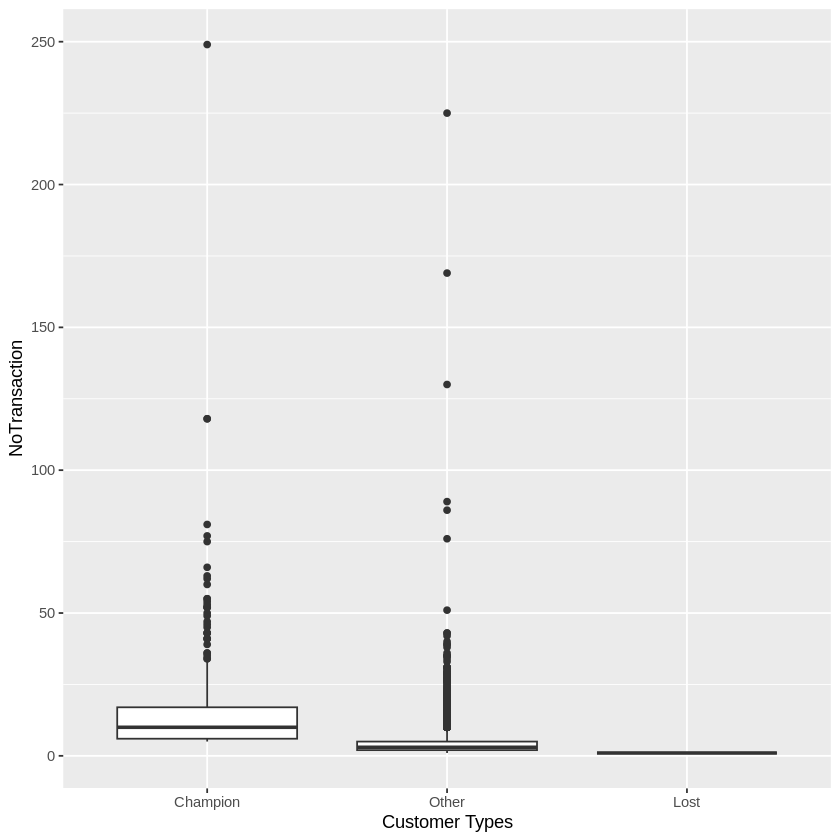

In [15]:
#Frequency comparison
ggplot(resultsRFM,aes(x=Segment,y=NoTransaction))+geom_boxplot()+labs(x="Customer Types")

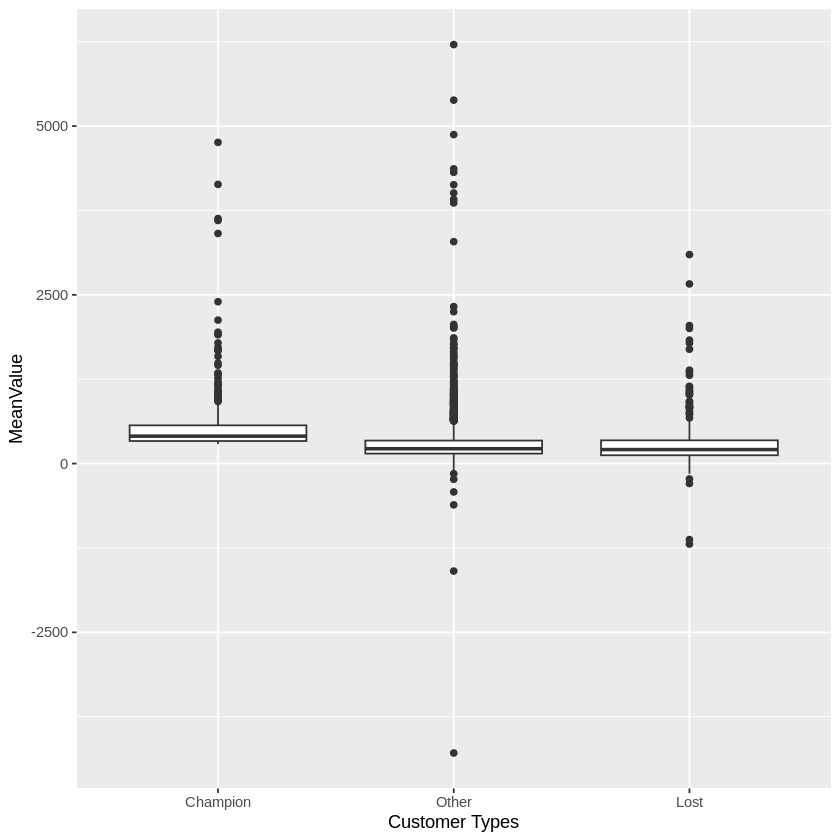

In [16]:
#Monetary comparison
ggplot(resultsRFM,aes(x=Segment,y=MeanValue))+geom_boxplot()+labs(x="Customer Types")

In [24]:
install.packages('dplyr')
library(dplyr)
Champions <- subset(resultsRFM, (RecencyScore>=4 & FrequencyScore>=4 &
                                      MonetoryScore>=4))
Champions$CustomerID <- as.numeric(Champions$CustomerID)
Champions_analysis <- right_join(retailonline, Champions, by='CustomerID')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [48]:
Lost <- subset(resultsRFM, (RecencyScore <=1 & FrequencyScore <= 1))
Lost$CustomerID <- as.numeric(Lost$CustomerID)
Lost_analysis <- right_join(retailonline, Lost, by='CustomerID')

In [59]:
Champions_analysis %>%
group_by(Country) %>%
summarise(totalquantity=sum(Quantity),
                    totalamount=sum(Amount)) %>%
arrange(desc(totalquantity)) %>%
slice_head(n=5)

Country,totalquantity,totalamount
<chr>,<dbl>,<dbl>
United Kingdom,1763082,3174486.8
Netherlands,196719,279489.0
EIRE,134205,245956.8
Australia,78704,126506.1
France,62762,113841.0


In [58]:
Lost_analysis %>%
group_by(Country) %>%
summarise(totalquantity=sum(Quantity),
                    totalamount=sum(Amount)) %>%
arrange(desc(totalquantity)) %>%
slice_head(n=5)

Country,totalquantity,totalamount
<chr>,<dbl>,<dbl>
United Kingdom,76925,129126.60
France,1579,3596.50
Germany,1153,2185.93
Channel Islands,1015,2148.24
Italy,962,2277.53


We can see that UK, Netherlands, EIRE (Ireland), Australia, and Germany were the Top 5 most ordered countries found among champion customers while UK, France, Greece, Italy, and Germany were ranked as Top 5 among lost customers.

Based on the numbers, there is no doubt that UK is the primary market. Customer service might want to focus on satisfying lost customers in Top 5 countries to see if there are any regional, linguistic or cultural issues.  

In [64]:
Champions_analysis %>%
group_by(Description) %>%
summarise(totalquantity=sum(Quantity),
                    totalamount=sum(Amount)) %>%
arrange(desc(totalamount)) %>%
slice_head(n=5)

Description,totalquantity,totalamount
<chr>,<dbl>,<dbl>
REGENCY CAKESTAND 3 TIER,7439,83876.10
WHITE HANGING HEART T-LIGHT HOLDER,19709,54040.05
JUMBO BAG RED RETROSPOT,28634,51892.11
PARTY BUNTING,7195,31485.43
ASSORTED COLOUR BIRD ORNAMENT,19855,30961.03


In [63]:
Lost_analysis %>%
group_by(Description) %>%
summarise(totalquantity=sum(Quantity),
                    totalamount=sum(Amount)) %>%
arrange(desc(totalamount)) %>%
slice_head(n=5)

Description,totalquantity,totalamount
<chr>,<dbl>,<dbl>
SMALL POPCORN HOLDER,4428,3204.80
REGENCY CAKESTAND 3 TIER,257,3046.35
WHITE HANGING HEART T-LIGHT HOLDER,654,1839.70
RED HARMONICA IN BOX,1569,1695.25
PARTY BUNTING,365,1674.15


REGENCY CAKESTAND 3 TIER, WHITE HANGING HEART T-LIGHT HOLDER and PARTY BUNTING are profitable products regardless of the customer segment, so putting extra attention on how to retain lost customers with strategies such as membership discounts, upselling and cross-selling other popular products would be crucial.  